# Bi-LSTM-CRF 

The following notebook contains code and instructions for transforming custom-labeled data (using Doccano) 

Built from code available here: https://github.com/PythonWorkshop/intro-to-nlp-with-pytorch



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
!pip install seqeval
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## LSTM Networks

There is an LSTM cell for each $x_t$ in the input vector, and there are hidden states $h_t$ that are either passed into the output layer or are transferred into the cell on the right. There is also a cell state $C_t$, which is updated using gates that are composed of activation functions ($\sigma, \tanh$) and matrix operations that are applied to the tensors in the LSTM network.

### The activation functions

- Sigmoid $\sigma$
    - Squishes values between 0 and 1, with an S shape
- $\tanh$
    - Squishes values between -1 and 1, with an S shape

### The gates

Used to pass information to adjust the cell-state of the LSTM

- *Forget Gate*
    - Decides what information that you want the network to forget. Remove that from the cell-state. Uses sigmoid Layer
    - Takes in previous hidden state and removes current state of target values likelihood.

$$
f_t = \sigma(W_f [h_{t-1}, x_t] + b_f)
$$

- *Input Gate*
    - Decides what information should be stored in the cell state (what information is important), decide what to update with a sigmoid $\sigma$ layer ($i_t$), and creates candidate values for the cell state using $\tanh$ layer ($\tilde{C}_t$)
    - This gate will replace previous likelihood for target value with likelihood of not being the target value.

$$
\begin{aligned}
i_t &= \sigma(W_f [h_{t-1}, x_t] + b_f) \\
\tilde{C}_t &= \tanh(W_C [h_{t-1}, x_t] + b_C)
\end{aligned}
$$

**Update Cell State**

Following the aformentioned gates, updates to the cell state occur using multiplication of $f_t * C_{t-1}$ and the additions of new candidate values, scaled by their importance $(i_t * \tilde{C}_t)$ to the cell state.

$$
C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
$$

- *Output Gate*
    - returns a filtered version of the cell state by multiplying the matrix from the sigmoid function $o_t$ with the $\tanh$ applied to the cell state $C_t$.
    - This gate tracks the magnitude of previous states and how they apply to the prediction of our target state.
    - The resulting hidden state $h_t$ can be split to return the prediction at that time step, or pass that to a later timestep for another LSTM

$$
\begin{aligned}
o_t &= \sigma(W_o [h_{t-1}, x_t] + b_o) \\
h_t &= o_t * \tanh(C_t)
\end{aligned}
$$

### Input and Dimensions

We need to be able to map our words and our labels to a dictionary of integer values for computing within the neural net.

### Loss Function

Negative Log Likelihood is often used. NLL identifies the smallest $-\log(P(word))$

## Bidirectional LSTM Networks

https://www.youtube.com/watch?v=5rZvUpd-4Kk

https://github.com/PythonWorkshop/intro-to-nlp-with-pytorch/blob/master/Named_Entity_Recognition/NamedEntityRecognition.ipynb

https://github.com/jidasheng/bi-lstm-crf/blob/master/bi_lstm_crf/model/crf.py

https://paperswithcode.com/paper/bidirectional-lstm-crf-models-for-sequence/review/

https://arxiv.org/pdf/1508.01991.pdf

Each word becomes a word embedding, and each sentence is a training point. Word embedding enters the cell of a nonlinear LSTM layer. In a bidirectional LSTM, the data are trained forwards on the first set of LSTM and backwards on a second set of LSTMs. Ultimately, these two LSTM layers give us bi-directional context that help us understand the boundaries of entities.

Why Bi-directional?
- Unidirectional LSTM can only account for context from the past; thus, the $h_t$ hidden state takes only past information as input.

This bi-directionality is especially useful for chunking and tagging because it can 

Ultimately, the forward and backward LSTMs produce two hidden states, then we concatenate those vectors and apply the big vector to the *conditional random field*. 

Note: LSTM addresses the vanishing gradient problem with cell state and non linear activation function layers.

## Decoder

Aside from the contextual power of the LSTM, the BiLSTM-CRF architecture is powerful because of the decoder (Viterbi) that uses a conditional random field to map the probability of transitioning from a tag of each type to a tage of any other type at the next time step. The decoding occurs by finding paths through 

### Conditional Random Field

A conditional random field consists of a transition matrix, "the costs of transitioning from a tag to another tag", wherein we use a scheme for labeling the relative position of words in a single named entity. One common application is the *B-I-O* (beginning-inner-outer).

Each data-point will give you a transition matrix like B to I or I to O or O to O. There are somethings that are less likely to happen, like an O to I. 

The Conditional Random Field is based upon a matrix of parameters, $V$, wherein the length of each row (number of columns) is equal to the tag set space, and the rows represent each of the words (features) in the sentence (sequence)


$$
\begin{aligned}
P(x|y) &= \frac{1}{Z(x)}\exp(\sum^M_{j=1}(A_{y^t,y^{t-1}}+ O_{y^t,x^t}))
\\
\\
Z(x) &= \sum_{y'}\exp\{F(y', x)\}
\end{aligned}
$$

^This is a first order sequential logistic regression.

### Viterbi Algorithm

Prediction is using the $P(x|y)$ to find the most likely argument; i.e.

$$
\text{argmax}_{y}\sum^M_{j=1}(A_{y^t,y^{t-1}}+ O_{y^t,x^t})
$$

The conditional random field and viterbi algorithm take the concatenated vector of hidden states and decodes them. These give us a likely sequence through each data point (sentence); this is what the Bi-LSTM-crf for Named Entity Recognition does.

So, if we have a bunch of transition matrices, i.e. possible paths through a sentence with different sequences of those tags. The viterbi algorithm finds the most likely path. It finds this "survivor path" based on a cost function that eliminates paths that have higher edge weights between connections.

In the code: There is a viterbi decoder (decodes the transition matrix values), a cost function, and returns a probability with the path.

The final value that the cost function evalueates is the sum of the corresponding values from the transition matrices and the LSTM output features mapped onto the tag space.

## Bi-LSTM Structural Outline

- Word Embeddings
- Forward LSTM (w/ hidden in/out)
- Backwards LSTM (w/ hidden in/out)
- Output Layer (Linear Layer from hidden to tagset size)
- CRF layer (Transition matrix and Viterbi Algorithm)

In [3]:
import torch
torch.__version__

'1.10.0+cu111'

In [4]:
# Imports for this tutorial
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import json
from collections import defaultdict, OrderedDict
import math
import numpy as np
import random

torch.manual_seed(1)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Set helper function

In [6]:
def argmax(vec):
    """Return the maximum argument as a"""
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    """
    Input:
        seq - the sequence (array)
        to_ix - the indices to which seqence values are converted (dict)

    Output:
        Numerical tensor
        """
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def log_sum_exp(vec):
    """Compute log sum exp in a numerically stable way for 
    the forward algorithm"""
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

Use Docano to label the data

Install Postgres and Doccano

Code for Porting from Doccano to format for the BI-LSTM-CRF

In [7]:
# Read export file
with open('/content/drive/MyDrive/ML_Models/Bi-LSTM/doccano_output.jsonl', 'r') as f:
    lines = f.readlines()

print(json.loads(lines[40]))
print(len(lines))

{'id': 11195, 'data': 'DAMON CARSON J.D.', 'label': [[0, 6, 'B-PER'], [6, 13, 'I-PER'], [13, 17, 'B-POS']]}
108


In [8]:


# The numerical doccano label to actual label (B-I-O scheme)

ix_to_label = {8: 'O', 7: 'I-ORG', 6:'B-ORG', 5:'I-POS', 4:'B-POS', 3: 'I-PER', 2: 'B-PER'}
    
# train/test data
data = []

# Vocabulary
vocab = set()
    
# Loop over each data point (a corpus of labeled text) to extract words
for line in lines:
    # An ordered dict will keep items in order for further manipulation
    # so we initialize here
    orddict = OrderedDict({})
    # Lists to hold the words and labels
    words = []
    labels = []
    # Convert line to json
    input_json = json.loads(line)
    annots = input_json['label']
    text = input_json['data']
    
    # Add each word annotation to OrderedDict
    for ann in annots:
        orddict[ann[0]] = ann
    
    # Sort ordered dict because there's no guarantee reading json
    # maintained order
    orddict = sorted(orddict.items(), key=lambda x: x[1][0])
    
    for item in orddict:
        # the item is a tuple where second value is the actual value we want
        ann = item[1]
        # Subset text string
        word = text[ann[0]:(ann[1])].rstrip()
        label = ann[2]
        # Add to list for this datum/corpus
        words.append(word)
        labels.append(label)
        vocab.add(word)
    # Add to overall data containers
    data.append((words, labels))

In [9]:
len(vocab)

1490

Split Train and Test

In [10]:
random.shuffle(data)
num_train = math.floor(len(data) * 0.8) # 80% to train
training_data, test_data = data[:num_train], data[num_train:]
len(test_data)

22

In [11]:
len(vocab)

1490

## Train

### Create Network

In [12]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, mini_batch):
        """Initialize network."""
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.mini_batch = mini_batch
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim) # Create word embedding layer (linear layer)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, #Split our hidden dimension because it's creating two sets of LSTM cells
                            bidirectional=True) 

        # Creates feature vectors from the concatenated hidden states output from the LSTM layers
        # Turns it into a format that CRF can use
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Initialize matrix of randomized transition values and add it to our model with nn.Parameter 
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))

        # Enforce constraints on the transition matrix if the sequence...
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000 # stops at a start tag
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000 # starts at a stop tag

        self.hidden = self.init_hidden()
    
    def init_hidden(self):
        """Two tensors to hold hidden states, one for each
        LSTM direction with dimensions of 
        (num_layers, minibatch, hidden_dim)"""
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))
    
    def _forward_alg(self, feats):
        """Forward pass of our training algorithm. 
        The central process of the CRF.

        Input:
            The word embeddeding vectors for a sentence

        Iterates through features and through the tag set space. 
        Evaluates the cost of transitioning to each tag in the tag space.
        This gives us new tranistion matrix values and returns a loss via log_sum_exp"""
        # Compute partition function for 
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG ("<START>") has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        forward_var = init_alphas

        # Iterate through sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            # Iterate through the tag_set space
            for next_tag in range(self.tagset_size):
                # emit_score: "Emission Score" p(w_i|t_i)
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                # tans_score: "Transition Score" P(t_i | t_i-1)
                trans_score = self.transitions[next_tag].view(1, -1)
                # next_tag_var: Edge values connecting feature with subsequent tag
                # edge (i -> next_tag)
                next_tag_var = forward_var + trans_score + emit_score
                # alpha_t contains the log-sum-exp of all the scores for each feature and it's edges.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            # concatenate the alphas_t into a vector
            forward_var = torch.cat(alphas_t).view(1, -1)


        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]

        alpha = log_sum_exp(terminal_var)
        return alpha # RETURNS THE LOSS
    
    def _get_lstm_features(self, sentence):
        """Compute output vector of BiLSTM - used in 
        the forward pass of network
        
        This returns the feature vector with the shape that the CRF requires"""
        self.hidden = self.init_hidden() #take hidden states
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) # Reshape word embeddings to len of sentence
        lstm_out, self.hidden = self.lstm(embeds, self.hidden) # run those word embeddings through an lstm
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim) # return feature vectors to reshape into shape (len(sentence), hidden_dim)
        # Map LSTM features into tag space
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats


    def _score_sentence(self, feats, tags):
        """Gives the score of a provided tag sequence
        
        Inputs:
            feats: feature output from _get_lstm_features(sentence)
            tags: the tags for NER
        """
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]] #accumulate score of transitions_MATRIX[next_tag, current tag] + score of next feature[tag]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        """This is used when we are scoring and doing inference (after training)

        We take the maximum transition value (most likely transition) over the previous states.

        Input:
            loglikelihoods: torch tensor.

        Output:
            tuple: (loglikelihood(sequence), sequence). The first entry is the loglikelihood of this sequence. The second is the most likely sequence of labels. 
        """
        backpointers = [] # will store the transition values

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats: #for each word in sequence
            backptrs_t = []  # holds the backpointers
            viterbivars_t = []  # holds the viterbi variables

            for next_tag in range(self.tagset_size):
                # next_tag_var[i]: the sum of the viterbi variable for tag `i` at the previous step `t` and the score of transitioning from tag i to next_tag.
                next_tag_var = forward_var + self.transitions[next_tag]
                # Store the maximum score from this sum and append the id to list of backpointers
                best_tag_id = argmax(next_tag_var)
                backptrs_t.append(best_tag_id)
                # Append the value associated with best_tag_id
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Add emission scores, and use forward_var to store the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1).to(device)
            backpointers.append(backptrs_t)

        # Transition to STOP_TAG to complete path
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        # Store path scores
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for backpointers_t in reversed(backpointers):
            best_tag_id = backpointers_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        """Calculate the negative log likelihood given a sequence and labels.
        This is used in training because the score output is used for the loss"""
        # Get output of Bi-LSTM
        feats = self._get_lstm_features(sentence)
        # Do forward pass through network to get score for training attempted path
        forward_score = self._forward_alg(feats)
        # The score we get from the pre-labeled path
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):
        """The forward pass function for training the network.
        This is used in inference only."""
        # Get the emission scores (output layer) from the 
        # BiLSTM 
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [13]:
# Hyper-Parameters for the model
EMBEDDING_DIM = len(vocab) # Non-specific embedding dimension parameter, but is normally = to length of vocabulary.
HIDDEN_DIM = 6 # Hidden dimensions detemines shape of the LSTM output.
MINIBATCH_SIZE = 1
LEARNING_RATE = 5e-2 # 0.05

Pre Check

In [14]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"

# Create a lookup dict for all possible words and record their index
word_to_ix = {k: v for (k, v) in zip(vocab, range(len(vocab)))}
tag_to_ix = {"B-PER": 0, "I-PER": 1, "B-POS":2, "I-POS":3, "B-ORG":4, "I-ORG": 5, "O": 6, START_TAG: 7, STOP_TAG: 8}
ix_to_tag = {0: "B-PER", 1: "I-PER", 2:"B-POS", 3:"I-POS", 4: "B-ORG", 5:"I-ORG", 6: "O"}

In [15]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, 16)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [16]:
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[1][0], word_to_ix)
    precheck_sent = precheck_sent.to(device)
    pred =  model(precheck_sent)[1]
    print('Prediction:   ', [ix_to_tag[idx] for idx in pred])
    print('Ground truth: ', training_data[1][1])
    print(training_data[1][0], "\n", len(training_data[1][0]))

Prediction:    ['I-PER', 'I-POS', 'I-PER', 'I-POS', 'I-PER', 'B-PER', 'B-POS', 'B-PER']
Ground truth:  ['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG']
['Society', 'for', 'Advancement', 'of', 'Chicanos', 'and', 'Native', 'Americans'] 
 8


Train Model

In [17]:
losses = []
for epoch in range(30):  
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance of LSTM
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)
        sentence_in, targets = sentence_in.to(device), targets.to(device)

        # Step 3. A lot happens.  Run our forward pass to get features from BLSTM,
        # run the CRF and get the negative log likelihoods and find the best 
        # "path" through sentence with the tags using the viterbi algorithm 
        # (also part of forward pass).
        # BTW our dynamic computational graph is created with the forward pass
        # Returns the forward score - ground truth score (our loss measure)
        loss = model.neg_log_likelihood(sentence_in, targets)
        losses.append(loss.item())


        # Step 4. Compute the loss, gradient, backprop, and update the 
        # parameters by calling optimizer.step() - optimizer here is 
        # SGD for our CRF
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print("Epoch: {} Loss: {}".format(epoch+1, np.mean(losses)))

Epoch: 10 Loss: 14.604023560535076
Epoch: 20 Loss: 13.05058504183625
Epoch: 30 Loss: 12.736434719405432


In [18]:
from sklearn.metrics import confusion_matrix
torch.save(model.state_dict(), 'drive/MyDrive/ML_Models/Bi-LSTM/model_2.pth')

### Training Eval

In [33]:
from seqeval.metrics import classification_report as classification_report_seqeval
model.eval() #changes the functional state of batch norm and dropout layers
pred_tags = []
truth_tags = []
pred_list = []
true_list = []

for i in range(len(training_data)):
    with torch.no_grad():
        precheck_sent = prepare_sequence(training_data[i][0], word_to_ix)
        precheck_sent = precheck_sent.to(device)
        pred =  model(precheck_sent)[1]
        pred_tags.append([ix_to_tag[idx] for idx in pred])
        #print('Prediction:   ', [ix_to_tag[idx] for idx in pred])
        #print('Ground truth: ', training_data[i][1])
        truth_tags.append(training_data[i][1])
        #print(training_data[i][0])
        pred_list.extend(pred_tags)
        true_list.extend(truth_tags)

correct = sum([pred_list[i] == true_list[i] for i in range(len(true_list))])
print("Training Accuracy: " + str(round(correct/len(pred_list)*100, 4)) + "%")
print(classification_report_seqeval(truth_tags, pred_tags))

confusion_matrix([x_i.split('-')[1] if x_i != 'O' else x_i for x in true_list for x_i in x], [x_i.split('-')[1] if x_i != 'O' else x_i for x in pred_list for x_i in x], labels = ['PER', 'POS', 'ORG', 'O'])

Training Accuracy: 10.5319%
              precision    recall  f1-score   support

         ORG       0.35      0.13      0.19       106
         PER       0.38      0.24      0.30        78
         POS       0.00      0.00      0.00        71

   micro avg       0.29      0.13      0.18       255
   macro avg       0.24      0.13      0.16       255
weighted avg       0.26      0.13      0.17       255



array([[  2003,   1607,    635,   2524],
       [   857,   3027,    301,   3281],
       [   818,   3320,   2940,   5354],
       [   727,   1864,   1582, 101434]])

### Test Eval

In [31]:
from seqeval.metrics import classification_report as classification_report_seqeval
model.eval() #changes the functional state of batch norm and dropout layers
pred_tags = []
truth_tags = []
pred_list = []
true_list = []

for i in range(len(test_data)):
    with torch.no_grad():
        precheck_sent = prepare_sequence(test_data[i][0], word_to_ix)
        precheck_sent = precheck_sent.to(device)
        pred =  model(precheck_sent)[1]
        pred_tags.append([ix_to_tag[idx] for idx in pred])
        #print('Prediction:   ', [ix_to_tag[idx] for idx in pred])
        #print('Ground truth: ', test_data[i][1])
        truth_tags.append(test_data[i][1])
        #print(test_data[i][0])
        pred_list.extend(pred_tags)
        true_list.extend(truth_tags)

correct = sum([pred_list[i] == true_list[i] for i in range(len(true_list))])
print("Validation Accuracy: " + str(round(correct/len(pred_list)*100, 4)) + "%")
print(classification_report_seqeval(truth_tags, pred_tags))
confusion_matrix([x_i.split('-')[1] if x_i != 'O' else x_i for x in true_list for x_i in x], [x_i.split('-')[1] if x_i != 'O' else x_i for x in pred_list for x_i in x], labels = ['PER', 'POS', 'ORG', 'O'])

Validation Accuracy: 11.0672%
              precision    recall  f1-score   support

         ORG       0.10      0.02      0.03        51
         PER       0.33      0.16      0.22        31
         POS       0.00      0.00      0.00        18

   micro avg       0.16      0.06      0.09       100
   macro avg       0.14      0.06      0.08       100
weighted avg       0.15      0.06      0.08       100



array([[ 149,  203,   70,  309],
       [  14,  185,   59,  267],
       [ 114,  913,  116, 1179],
       [  42,  503,   59, 1704]])

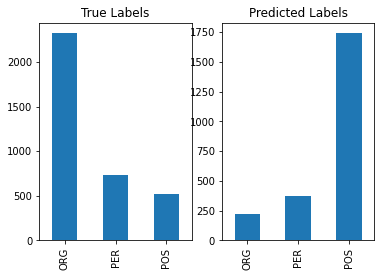

In [26]:
flat_labels = [x_i  for x in true_list for x_i in x]
pred_labels = [x_i  for x in pred_list for x_i in x]

original_s = pd.Series(flat_labels)
predicted_s = pd.Series(pred_labels)

stripped_original = original_s.loc[original_s != 'O'].apply(lambda x: x.split('-')[-1])
stripped_predicted = predicted_s.loc[predicted_s != 'O'].apply(lambda x: x.split('-')[-1])

fig, axes = plt.subplots(nrows=1, ncols=2)
stripped_original.value_counts().sort_index().plot(kind = 'bar', title = 'True Labels', ax=axes[0])
stripped_predicted.value_counts().sort_index().plot(kind = 'bar', title = 'Predicted Labels', ax=axes[1])